In [1]:
import utils
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump
from joblib import load
from sklearn.preprocessing import StandardScaler
import numpy as np
import pyreadstat
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from scipy.stats import mode
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import os
import glob

In [51]:
def compute_statistics(df_, time_col='tempo(s)', window_size=60, overlap=25): #if extracting only the simulator files swap 'tempo(s)_x' for 'tempo(s)'
    df = df_.copy()
    if time_col not in df.columns:
        raise ValueError(f"Column {time_col} not found in DataFrame.")

    # Convert the time column to seconds as a float
    df[time_col] = df[time_col].astype(float)
    
    # Separate 'Participant' data for preservation
    participant_data = df[['Participant', time_col]]
    participant_data.sort_values(by=time_col, inplace=True)  # Ensure participant_data is sorted
    
    # Convert all other columns to numeric, coercing errors, exclude 'Participant'
    numeric_cols = df.columns.difference(['Participant'])
    df_numeric = df[numeric_cols]
    for col in numeric_cols:
        df_numeric[col] = pd.to_numeric(df_numeric[col], errors='coerce')

    # Function to calculate all required statistics for each window
    def calculate_stats(window):
        stats = {}
        for column in window.columns:
            if column == time_col or column == 'sleepy':
                continue
            col_data = window[column].dropna()
            if col_data.empty:
                mode_val = np.nan
            else:
                mode_result = mode(col_data)
                if isinstance(mode_result.mode, np.ndarray):
                        mode_val = mode_result.mode[0] if mode_result.count > 0 else np.nan
                else:
                    mode_val = mode_result.mode if mode_result.count > 0 else np.nan

            stats[f'{column}_mean'] = col_data.mean()
            #uncomment the following lines if you want to include median and mode
            # stats[f'{column}_median'] = col_data.median()
            # stats[f'{column}_mode'] = mode_val 
            stats[f'{column}_std_dev'] = col_data.std()
        return pd.Series(stats)

    # Initialize an empty list to store results
    results = []

    # Define start and end times for the sliding windows
    window_size_sec = window_size
    overlap_sec = overlap
    start_time = df[time_col].iloc[0]

    while start_time + window_size_sec <= df[time_col].iloc[-1]:
        end_time = start_time + window_size_sec
        window = df_numeric[(df[time_col] >= start_time) & (df[time_col] < end_time)]
        if not window.empty:
            stats = calculate_stats(window)
            stats[time_col] = end_time  # Set the endpoint of the window as a column
            results.append(stats)
        start_time = start_time + (window_size_sec - overlap_sec)

    # Create a DataFrame from the results list
    results_df = pd.DataFrame(results)
    results_df.sort_values(by=time_col, inplace=True)  # Ensure results_df is sorted

    # Merge participant data back into results based on closest timestamp match
    results_df['Participant'] = participant_data.set_index(time_col).reindex(results_df[time_col], method='nearest')['Participant'].values

    # Rename column 'KSS_mean' to 'KSS'
    if 'KSS_mean' in results_df.columns:
        results_df.rename(columns={'KSS_mean': 'KSS'}, inplace=True)

    return results_df

## Manual Extraction

In [ ]:
base_path = utils.select_base_path()

In [ ]:
print('Eyetracker preparations...')
list_df_ver_left, list_df_ver_right, list_df_ver_ver = utils.extract_all('drowsiness', 'eyetracker', 'gaze all', 'csv', base_path)

In [ ]:
sinc_path = '/Users/henriqueribeiro/Desktop/Tese/sincronizacao_prof_rute/data_horas_sono.csv'

In [ ]:
print('Smartwatch preparations...')
smartwatch = utils.extract_all('drowsiness', 'smartwatch', None, 'csv', base_path)
smartwatch = utils.sinc_dataframes(smartwatch, 'smartwatch', sinc_path)
smartwatch = utils.prepare_smartwatch(smartwatch)

In [ ]:
sim_log = utils.extract_all('drowsiness', 'simulator', None, 'log', base_path)

In [ ]:
sim_txt, sim_dict = utils.extract_all('drowsiness','simulator', None,  'txt', base_path)

In [ ]:
print('Joining dataframes...')
ver = utils.join_vergences(list_df_ver_left, list_df_ver_right, list_df_ver_ver)
sinc_ver = utils.sinc_dataframes(ver, 'eyetracker', '/Users/henriqueribeiro/Desktop/Tese/sincronizacao_prof_rute/data_horas_sono.csv')


In [ ]:
merged_df = utils.join_log(sinc_ver, sim_log)
merged_df = utils.join_smartwatch_txt(merged_df, sim_txt, 'downsample')


In [ ]:
#remove column 'Participant_y' from merged_df_txt
merged_df = [df.drop('Participant_y', axis=1) for df in merged_df]
#rename column 'Participant_x' to 'Participant' in merged_df_txt
merged_df = [df.rename(columns={'Participant_x': 'Participant'}) for df in merged_df]

In [ ]:
smartwatch_correct = []
for participant_dir in os.listdir(base_path):   
        folder = f'{base_path}/{participant_dir}/sono_{participant_dir}_*_*_*/sono_{participant_dir}_smartwatch_*_*_*/*.csv'
        matches = glob.glob(folder)
if matches: 
    for i in tqdm(os.listdir(base_path)):   
        if i == '.DS_Store':
            continue
        # folder = f'{base_path}/{i}/sono_{i}_*_*_*/sono_{i}_smartwatch_*_*_*/*.csv'
        # matches = glob.glob(folder)
        # # Check if there is at least one match
        # if matches:
        
        df_watch = pd.read_csv(matches[0])
        #add a column to the df with the participant id
        df_watch['Participant'] = i.split('_')[1]
        #append the dataframe to the empty dataframe
    
        smartwatch_correct.append(df_watch)

In [ ]:
smartwatch_correct = utils.sinc_dataframes(smartwatch_correct, 'smartwatch', sinc_path)
smartwatch_correct = utils.prepare_smartwatch(smartwatch_correct)

In [ ]:
merged_full = utils.join_smartwatch_txt(merged_df, smartwatch_correct, 'other')

In [ ]:
# Assuming `list_of_dfs` is your list of DataFrame objects
merged_full = [compute_statistics(df) for df in merged_full]

In [ ]:
len(merged_full)

In [ ]:
merged_full[0].columns

In [ ]:
merged_full = [utils.add_metadata(df) for df in merged_full]


## Extracting only simulator files

If extracting files this way, might change a few things in the models

In [52]:
simulator = utils.extract_simulator('drowsiness')

Select the main files:
Extracting simulator files...


100%|██████████| 31/31 [04:51<00:00,  9.41s/it]


Extracting telnav files...


100%|██████████| 31/31 [00:00<00:00, 87.14it/s]


Do you wish to add participants' metadata? DISCLAIMER: It must be on .sav format and have a feature called ID (yes/no)
Do you wish select a .json file with the features to extract? (yes/no)


In [53]:
merged_full = simulator

## Extracting all files - Sim. + Smartwatch + Eyetracker

In [ ]:
merged_full = utils.extract_sim_sm_eyet('drowsiness')

## Clustering - Do not run

Needs further development

In [ ]:
merged_full[3]['Participant']

In [ ]:
len(merged_full)

In [ ]:
#from merged full, remove participants number 225 and 226
merged_full_ = [df for df in merged_full if df['Participant'].iloc[0] not in [225, 226, 228]]

In [ ]:
scaler = StandardScaler()
scaled_dfs = []
for df in merged_full:
    # Reset the index of df to ensure alignment
    df = df.reset_index(drop=True)
    # Perform scaling
    scaled_data = scaler.fit_transform(df.drop('Participant', axis=1))
    # Create a new DataFrame with the scaled data
    scaled_df = pd.DataFrame(scaled_data, columns=df.columns[1:])
    # Add the Participant column back to the scaled DataFrame
    scaled_df['Participant'] = df['Participant']
    scaled_dfs.append(scaled_df)

# Concatenate all scaled DataFrames
all_data_scaled = pd.concat(scaled_dfs, ignore_index=True)


In [ ]:
len(scaled_dfs)

In [ ]:
len(all_data_scaled)

In [ ]:
all_data_scaled['Participant'].tail()

In [ ]:
#remove null values from all_data_scaled
all_data_scaled = all_data_scaled.dropna()

In [ ]:
len(all_data_scaled)

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Example of using the elbow method to find the optimal number of clusters
wcss = []
for i in range(1, 11):  # testing 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(all_data_scaled.drop('Participant', axis=1))
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [ ]:
all_data_scaled.columns

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Let's assume all_data is your DataFrame after concatenating the 5 participant datasets
# And 'Participant' is the column that identifies the participant

# Step 1: Aggregate the data by participant
# Exclude the 'Participant' column and apply the aggregation to all other columns
participant_aggregated = all_data_scaled.groupby('Participant').agg(['mean', 'std', 'median']).reset_index()


selected_features = participant_aggregated[['Heart Rate_median', 'Heart Rate_mode',
                                             'vel(km/h)_median', 'vel(km/h)_mode',
                                             'ang_carro(rad)_median', 'ang_carro(rad)_mode'
       ]]

# Step 2: Scale the aggregated features (excluding 'Participant' column)
features = participant_aggregated.drop('Participant', axis=1)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Step 3: Apply K-means clustering
k = 4 # number of clusters, determined earlier
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
participant_clusters = kmeans.fit_predict(features_scaled)

# Step 4: Assign cluster labels back to the aggregated data
participant_aggregated['Cluster'] = participant_clusters

# Step 4.1: Optionally, join the cluster labels with the original dataset if needed
# all_data = all_data.merge(participant_aggregated[['Participant', 'Cluster']], on='Participant')

# Step 5: Visualize the Clusters with PCA
pca = PCA(n_components=2)  # Reduce the data to two components for visualization
principal_components = pca.fit_transform(features_scaled)

# Plot the clusters
plt.figure(figsize=(10, 8))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=participant_clusters, cmap='viridis', s=100)

# Optionally, annotate points with the participant identifier
for i, txt in enumerate(participant_aggregated['Participant']):
    plt.annotate(txt, (principal_components[i, 0], principal_components[i, 1]))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Cluster Visualization of Participants')
plt.colorbar(label='Cluster Label')
plt.show()

In [ ]:
list_of_clusters = [group for _, group in participant_aggregated.groupby('Cluster')]

In [ ]:
clusters = {}  # Initialize an empty dictionary

# Assuming list_of_clusters is a list of DataFrames or similar
for i, cluster_df in enumerate(list_of_clusters):
    cluster_key = i
    clusters[cluster_key] = []  # Create an empty list for each cluster
    
    for participant in cluster_df['Participant']:
        # Find the DataFrame in merged_full that contains the 'Participant' column equal to participant
        # Assuming merged_full is a list of DataFrames
        for df in merged_full:
            if participant in df['Participant'].values:
                clusters[cluster_key].append(df)
                break  # Break the loop once the matching df is found and added

In [ ]:
labeled_1 = []
for i in range(len(clusters[1])): 
    labeled = utils.create_sleepy(clusters[1][i])
    labeled_1.append(labeled) 

## Data Prep.

In [54]:
drop_first = ['X', 'Y', 'Z', 'IVIS', 'roaddist(m)', 'totaldistance(m)',
       'gear', 'piscas(2=Dtr,4=Esq,5=QtPisc)', 'ACC_sate',
       'Accspeed(km/h)', 'ACC_dist(s)', 'dist_frente(m)',
       'vel_frente(km/h)', 'TTC(s)', 'TH(s)', 'DH(m) )' ] #you can drop these or other columns that are not useful/might cause overfitting
for df in merged_full:
    df.drop(drop_first, axis=1, inplace=True)

In [55]:
merged_full = [compute_statistics(df) for df in merged_full]

In [56]:
merged_full = [utils.create_sleepy(df) for df in merged_full]

In [19]:
len(merged_full)

29

In [74]:
users_to_trainval = 24
users_to_test = 5

In [75]:
#merge first 6 dfs in labeled_1 
train_val = pd.concat(merged_full[:users_to_trainval], ignore_index=True)

In [76]:
test = pd.concat(merged_full[users_to_test:], ignore_index=True)

In [77]:
#print names of columns that contain null values in train_val
missing_columns = train_val.columns[train_val.isnull().any()]
print(missing_columns.tolist())


['Fiabilidade_mean', 'Fiabilidade_std_dev', 'KSS', 'KSS_std_dev']


In [78]:
columns_train = train_val.columns

selected_strings = [string for string in columns_train if string.endswith('_mean') or string.endswith('_std_dev')]


In [79]:
columns_to_drop = ['KSS', 'diff vol(rad)', 'diff tempo(s)', 'Fiabilidade'] #might need to add a few columns depending on the ones you want to drop
#add selected_strings to columns_to_drop

suffixes = ['_mean'] #, '_mode', '_std_dev', '_median'
modified_columns = []

# Loop through each column in the list
for column in columns_to_drop:
    if column not in ['KSS', 'sleepy', 'Participant']:  # Exclude 'KSS' from being modified
        for suffix in suffixes:
            modified_columns.append(column + suffix)  # Append each suffix to the column name
    else:
        modified_columns.append(column)  # Append 'KSS' without modification

# Now, modified_columns contains all original columns plus the new columns with suffixes
print(modified_columns)


['KSS', 'diff vol(rad)_mean', 'diff tempo(s)_mean', 'Fiabilidade_mean']


In [80]:
modified_columns.extend(selected_strings)

In [68]:
train_val = train_val.dropna()
test = test.dropna()

In [81]:
X_train_val = train_val.drop(modified_columns, axis=1).sample(frac=1, random_state=42)
y_train_val = train_val['sleepy']

X_test = test.drop(modified_columns, axis=1).sample(frac=1, random_state=42)
y_test = test['sleepy']

In [82]:
# check class balances on train/validation set
indices_class_0 = np.where(y_train_val == 0)[0]
indices_class_1 = np.where(y_train_val == 1)[0]

print(f'Indices class 0 for train/val set: {len(indices_class_0)}')
print(f'Indices class 1 for train/val set: {len(indices_class_1)}')

# check class balances on test set
indices_class_0_test= np.where(y_test == 0)[0]
indices_class_1_test = np.where(y_test == 1)[0]

print(f'Indices class 0 for test set: {len(indices_class_0_test)}')
print(f'Indices class 1 for test set: {len(indices_class_1_test)}')

Indices class 0 for train/val set: 943
Indices class 1 for train/val set: 1637
Indices class 0 for test set: 1303
Indices class 1 for test set: 2051


In [85]:
#Downsampling
# Downsample class 1
np.random.seed(42)  # For reproducibility
indices_class_1_downsampled = np.random.choice(indices_class_1, size=len(indices_class_0), replace=False)

# Combine indices to create the downsampled dataset
indices_downsampled = np.concatenate([indices_class_0, indices_class_1_downsampled])

# Shuffle the indices
np.random.shuffle(indices_downsampled)

# Create the downsampled X and y
X_train_val = X_train_val.iloc[indices_downsampled]
y_train_val = y_train_val.iloc[indices_downsampled]

# Check the new class distribution
print(f'New class distribution in downsampled dataset: {np.bincount(y_train_val)}')

New class distribution in downsampled dataset: [943 943]


# Generalized Approach

Same model for everyone

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_recall_curve
from sklearn.decomposition import PCA
import numpy as np

# Suppose best_features is defined as the features selected earlier
best_features = ['Heart Rate_median', 'Heart Rate_mode', 'Start Time (secs)_median',
                 'Start Time (secs)_mode', 'X Pos_median', 'Y Pos_median',
                 'ang_carro(rad)_median', 'eixo_offset(m)_median', 'eixo_offset(m)_mode',
                 'left pupil diameter_median', 'mean pupil diameter_median',
                 'perclos left_median', 'perclos mean_median', 'perclos right_median',
                 'right pupil diameter_median', 'tempo(s)_y_mode', 'vel(km/h)_median',
                 'vel_ang(rad/s)_rolling_std_median', 'vol(filt)_median', 'vol(filt)_mode']

# Reduce dimensionality using PCA
pca = PCA(n_components=10)  # Reduce to 10 components for simplicity
X_train_val_reduced = pca.fit_transform(X_train_val[best_features])
X_test_reduced = pca.transform(X_test_reordered[best_features])

# Define parameter grid with more regularization
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [6, 8, 10],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [2, 5, 10],
    'bootstrap': [True]
}

# Create model instance
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform GridSearchCV with the reduced feature set
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid_rf, scoring='f1', cv=cv, verbose=1, n_jobs=-1)
grid_search.fit(X_train_val_reduced, y_train_val)

# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best Parameters:", best_params)

# Train the best model on the full training data with selected features
best_model.fit(X_train_val_reduced, y_train_val)

# Validate the best model
val_pred_prob = best_model.predict_proba(pca.transform(X_train_val[best_features]))[:, 1]
train_pred_prob = best_model.predict_proba(X_train_val_reduced)[:, 1]

# Find the optimal threshold
precision, recall, thresholds = precision_recall_curve(y_train_val, val_pred_prob)
f1_scores = 2 * recall * precision / (recall + precision)
optimal_threshold = thresholds[np.argmax(f1_scores)]
print("Optimal Threshold:", optimal_threshold)

val_pred = (val_pred_prob > optimal_threshold).astype(int)
train_pred = (train_pred_prob > optimal_threshold).astype(int)

accuracy = accuracy_score(y_train_val, val_pred)
f1 = f1_score(y_train_val, val_pred)
f1_train = f1_score(y_train_val, train_pred)
train_accuracy = accuracy_score(y_train_val, train_pred)
auc_val = roc_auc_score(y_train_val, val_pred)
auc_train = roc_auc_score(y_train_val, train_pred)

print(f'Training accuracy: {train_accuracy}')
print(f'Validation accuracy: {accuracy}')
print(f"Training F1 Score:", f1_train)
print(f"Validation F1 Score:", f1)
print(f'Training AUC Score:', auc_train)
print(f'Validation AUC Score:', auc_val)

# Test the best model
test_pred_prob = best_model.predict_proba(X_test_reduced)[:, 1]
test_pred = (test_pred_prob > optimal_threshold).astype(int)

accuracy_test = accuracy_score(y_test, test_pred)
f1_score_test = f1_score(y_test, test_pred)
auc_test = roc_auc_score(y_test, test_pred)

print(f'Test Accuracy: {accuracy_test:.2f}')
print(f'Test F1 Score: {f1_score_test:.2f}')
print(f'Test AUC Score: {auc_test:.2f}')


In [ ]:
#confusion matrix of the test set
conf_matrix = confusion_matrix(y_test, test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

## Random Forest

In [103]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


rforest_model = RandomForestClassifier(n_estimators=100, min_samples_split = 20,min_samples_leaf = 5,random_state=42, max_depth=8, bootstrap=True)
accuracies = []
f1_scores= []
auc_scores = []

# # Setup GridSearchCV
# rf_model = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='accuracy', cv=3, verbose=1)

total_train_samples_per_class = 900  # Total samples available for training per class
validation_size_per_class = 100  # Fixed number of samples per class for validation

initial_train_size_per_class = 200  # Initial size of training set per class in the first fold
train_increment_per_fold = 50  # Number of samples to add to training set per class in each subsequent fold

# Get indices for each class
indices_class_0 = np.where(y_train_val == 0)[0]
indices_class_1 = np.where(y_train_val == 1)[0]

# Shuffle indices to ensure randomness
np.random.seed(42)
np.random.shuffle(indices_class_0)
np.random.shuffle(indices_class_1)

# Setup validation set from the end of shuffled indices
validation_indices = np.concatenate([
    indices_class_0[-validation_size_per_class:],
    indices_class_1[-validation_size_per_class:]
])

# Indices available for training
train_indices_class_0 = indices_class_0[:-validation_size_per_class]
train_indices_class_1 = indices_class_1[:-validation_size_per_class]

# Initialize the folds list
folds_indices = []
list_accuracy_training = []
list_accuracy_validation = []
list_f1_training = []
list_f1_validation = []
list_auc_training = []
list_auc_validation = []
# Setup training and validation indices for each fold
current_train_size_per_class = initial_train_size_per_class

while current_train_size_per_class <= total_train_samples_per_class:
    train_indices = np.concatenate([
        train_indices_class_0[:current_train_size_per_class],
        train_indices_class_1[:current_train_size_per_class]
    ])

    # Shuffle train indices if desired
    np.random.shuffle(train_indices)

    # Append current fold's train and validation indices
    folds_indices.append((train_indices, validation_indices.copy()))

    # Increase the train set size for the next fold
    current_train_size_per_class += train_increment_per_fold

for i, (train_indices, validation_indices) in enumerate(folds_indices):
    fold = i+1
    print(f"Fold {fold}:")
    # print("Train Indices:", train_indices)
    # print("Validation Indices:", validation_indices)

    X_train_fold = X_train_val.iloc[train_indices]
    X_val_fold = X_train_val.iloc[validation_indices]
    y_train_fold = y_train_val.iloc[train_indices]
    y_val_fold = y_train_val.iloc[validation_indices]

    class_labels = [0,1]  
    
    print('Training set class distribution:')
    for i, count in enumerate(np.bincount(y_train_fold)):
        if i < len(class_labels):  # Check to ensure there's a label for the class index
            print(f'{class_labels[i]}: {count}')

    print('Validation set class distribution:')
    for i, count in enumerate(np.bincount(y_val_fold)):
        if i < len(class_labels):  # Same check as above
            print(f'{class_labels[i]}: {count}')


    # Train model
    rforest_model.fit(X_train_fold, y_train_fold) #, eval_set = [(X_train_fold, y_train_fold), (X_val_fold, y_val_fold)] ,verbose=True)

    # Validate model
    val_pred = rforest_model.predict(X_val_fold)
    train_pred = rforest_model.predict(X_train_fold)
    threshold = 0.5
    val_pred = (val_pred > threshold).astype(int)
    train_pred = (train_pred > threshold).astype(int)
    accuracy = accuracy_score(y_val_fold, val_pred)
    f1 = f1_score(y_val_fold, val_pred)
    f1_train = f1_score(y_train_fold, train_pred)
    train_accuracy = accuracy_score(y_train_fold, train_pred)

    auc_val = roc_auc_score(y_val_fold, val_pred)
    auc_train = roc_auc_score(y_train_fold, train_pred)
    list_accuracy_training.append(train_accuracy)
    list_accuracy_validation.append(accuracy)
    list_f1_training.append(f1_train)
    list_f1_validation.append(f1)
    list_auc_training.append(auc_train)
    list_auc_validation.append(auc_val)
    print(f'Training accuracy for fold {fold}: {train_accuracy}')
    print(f'Validation accuracy for fold {fold}: {accuracy}')

    print(f"Training F1 Score for fold {fold}:", f1_train)
    print(f"Validation F1 Score for fold {fold}:", f1)

    print(f'Training AUC Score for fold {fold}:', auc_train)
    print(f'Validation AUC Score for fold {fold}', auc_val)
    


    accuracies.append(accuracy)

    # Increment fold index
    #fold += 1

    print('')

# Reorder the columns of X_test to match the order of X_train
# Get the column names of X_train
train_columns = X_train_val.columns
X_test_reordered = X_test[train_columns]
rforest_model.fit(X_train_val, y_train_val)
test_pred = rforest_model.predict(X_test_reordered)
threshold = 0.5
test_pred = (test_pred > threshold).astype(int)
accuracy_test = accuracy_score(y_test, test_pred)
f1_score_test = f1_score(y_test, test_pred)
auc_test = roc_auc_score(y_test, test_pred)

print(f'Mean of the Train Accuracy: {np.mean(list_accuracy_training)}')
print(f'Mean of the Train F1 Score: {np.mean(list_f1_training)}')
print(f'Mean of the Train AUC Score: {np.mean(list_auc_training)}\n')


print(f'Mean of the Validation Accuracy: {np.mean(list_accuracy_validation)}')
print(f'Mean of the Validation F1 Score: {np.mean(list_f1_validation)}')
print(f'Mean of the Validation AUC Score: {np.mean(list_auc_validation)}\n')


print(f'Standard Deviation of the Train Accuracy: {np.std(list_accuracy_training)}')
print(f'Standard Deviation of the Train F1 Score: {np.std(list_f1_training)}')
print(f'Standard Deviation of the Train AUC Score: {np.std(list_auc_training)}\n')

print(f'Standard Deviation of the Validation Accuracy: {np.std(list_accuracy_validation)}')
print(f'Standard Deviation of the Validation F1 Score: {np.std(list_f1_validation)}')
print(f'Standard Deviation of the Validation AUC Score: {np.std(list_auc_validation)}\n')

print(f'Test Accuracy: {accuracy_test:.2f}')
print(f'Test F1 Score: {f1_score_test:.2f}')
print(f'Test AUC Score: {auc_test:.2f}')

Fold 1:
Training set class distribution:
0: 200
1: 200
Validation set class distribution:
0: 100
1: 100
Training accuracy for fold 1: 0.6825
Validation accuracy for fold 1: 0.51
Training F1 Score for fold 1: 0.6768447837150128
Validation F1 Score for fold 1: 0.49484536082474223
Training AUC Score for fold 1: 0.6825
Validation AUC Score for fold 1 0.51

Fold 2:
Training set class distribution:
0: 250
1: 250
Validation set class distribution:
0: 100
1: 100
Training accuracy for fold 2: 0.704
Validation accuracy for fold 2: 0.535
Training F1 Score for fold 2: 0.6967213114754098
Validation F1 Score for fold 2: 0.5181347150259067
Training AUC Score for fold 2: 0.7040000000000001
Validation AUC Score for fold 2 0.535

Fold 3:
Training set class distribution:
0: 300
1: 300
Validation set class distribution:
0: 100
1: 100
Training accuracy for fold 3: 0.7116666666666667
Validation accuracy for fold 3: 0.5
Training F1 Score for fold 3: 0.7072758037225042
Validation F1 Score for fold 3: 0.5
Trai

Text(0.5, 1.0, 'Confusion Matrix')

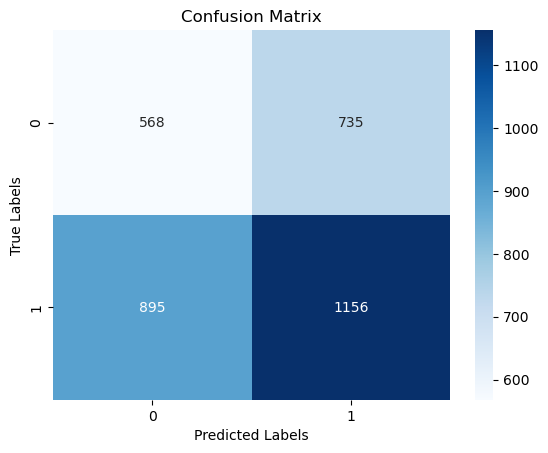

In [104]:
#confusion matrix of the test set
conf_matrix = confusion_matrix(y_test, test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

## Gradient Boost

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


gb_model_start = GradientBoostingClassifier(n_estimators=125, learning_rate=0.1, max_depth=3,  min_samples_split=50,
                                min_samples_leaf=8, subsample=0.8,random_state=42)

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [30, 50, 70],
    'min_samples_leaf': [1, 5, 10],
    'subsample': [0.7, 0.8, 0.9]
}

gb_model = GridSearchCV(estimator=gb_model_start, param_grid=param_grid, scoring='accuracy',
                           cv=3, verbose=1, n_jobs=-1)

# # Define the parameter grid
# param_grid = {
#     'reg_alpha': [0.001, 0.01, 0.1, 1, 10],  # L1 regularization strengths
#     'reg_lambda': [0.001, 0.01, 0.1, 1, 10]  # L2 regularization strengths
# }

# # Setup GridSearchCV
# rf_model = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='accuracy', cv=3, verbose=1)

total_train_samples_per_class = 780  # Total samples available for training per class
validation_size_per_class = 60  # Fixed number of samples per class for validation

initial_train_size_per_class = 200  # Initial size of training set per class in the first fold
train_increment_per_fold = 100  # Number of samples to add to training set per class in each subsequent fold

# Get indices for each class
indices_class_0 = np.where(y_train_val == 0)[0]
indices_class_1 = np.where(y_train_val == 1)[0]

# Shuffle indices to ensure randomness
np.random.seed(42)
np.random.shuffle(indices_class_0)
np.random.shuffle(indices_class_1)

# Setup validation set from the end of shuffled indices
validation_indices = np.concatenate([
    indices_class_0[-validation_size_per_class:],
    indices_class_1[-validation_size_per_class:]
])

# Indices available for training
train_indices_class_0 = indices_class_0[:-validation_size_per_class]
train_indices_class_1 = indices_class_1[:-validation_size_per_class]

# Initialize the folds list
folds_indices = []
list_accuracy_training = []
list_accuracy_validation = []
list_f1_training = []
list_f1_validation = []
list_auc_training = []
list_auc_validation = []
# Setup training and validation indices for each fold
current_train_size_per_class = initial_train_size_per_class

while current_train_size_per_class <= total_train_samples_per_class:
    train_indices = np.concatenate([
        train_indices_class_0[:current_train_size_per_class],
        train_indices_class_1[:current_train_size_per_class]
    ])

    # Shuffle train indices if desired
    np.random.shuffle(train_indices)
    # Append current fold's train and validation indices
    folds_indices.append((train_indices, validation_indices.copy()))

    # Increase the train set size for the next fold
    current_train_size_per_class += train_increment_per_fold


for i, (train_indices, validation_indices) in enumerate(folds_indices):
    fold = i+1
    print(f"Fold {fold}:")
    # print("Train Indices:", train_indices)
    # print("Validation Indices:", validation_indices)

    X_train_fold = X_train_val.iloc[train_indices]
    X_val_fold = X_train_val.iloc[validation_indices]
    y_train_fold = y_train_val.iloc[train_indices]
    y_val_fold = y_train_val.iloc[validation_indices]

    class_labels = [0,1]  
    
    # print('Training set class distribution:')
    # for i, count in enumerate(np.bincount(y_train_fold)):
    #     if i < len(class_labels):  # Check to ensure there's a label for the class index
    #         print(f'{class_labels[i]}: {count}')

    # print('Validation set class distribution:')
    # for i, count in enumerate(np.bincount(y_val_fold)):
    #     if i < len(class_labels):  # Same check as above
    #         print(f'{class_labels[i]}: {count}')

    print('Training set class distribution:')
    for i, count in enumerate(np.bincount(y_train_fold)):
        if i < len(class_labels):  # Check to ensure there's a label for the class index
            print(f'{class_labels[i]}: {count}')

    print('Validation set class distribution:')
    for i, count in enumerate(np.bincount(y_val_fold)):
        if i < len(class_labels):  # Same check as above
            print(f'{class_labels[i]}: {count}')
    # Train model
    gb_model_start.fit(X_train_fold, y_train_fold) #, eval_set = [(X_train_fold, y_train_fold), (X_val_fold, y_val_fold)] ,verbose=True)

    # Validate model
    val_pred = gb_model_start.predict(X_val_fold)
    train_pred = gb_model_start.predict(X_train_fold)
    threshold = 0.5
    val_pred = (val_pred > threshold).astype(int)
    train_pred = (train_pred > threshold).astype(int)
    accuracy = accuracy_score(y_val_fold, val_pred)
    f1 = f1_score(y_val_fold, val_pred)
    f1_train = f1_score(y_train_fold, train_pred)
    train_accuracy = accuracy_score(y_train_fold, train_pred)

    auc_val = roc_auc_score(y_val_fold, val_pred)
    auc_train = roc_auc_score(y_train_fold, train_pred)
    list_accuracy_training.append(train_accuracy)
    list_accuracy_validation.append(accuracy)
    list_f1_training.append(f1_train)
    list_f1_validation.append(f1)
    list_auc_training.append(auc_train)
    list_auc_validation.append(auc_val)
    print(f'Training accuracy for fold {fold}: {train_accuracy}')
    print(f'Validation accuracy for fold {fold}: {accuracy}')

    print(f"Training F1 Score for fold {fold}:", f1_train)
    print(f"Validation F1 Score for fold {fold}:", f1)

    print(f'Training AUC Score for fold {fold}:', auc_train)
    print(f'Validation AUC Score for fold {fold}', auc_val)
    


    accuracies.append(accuracy)

    # Increment fold index
    #fold += 1

    print('')

# Reorder the columns of X_test to match the order of X_train
# Get the column names of X_train
train_columns = X_train_val.columns
X_test_reordered = X_test[train_columns]






gb_model_start.fit(X_train_val, y_train_val)
threshold = 0.65
#test_pred = gb_model_start.predict(X_test_reordered)
test_proba = gb_model_start.predict_proba(X_test_reordered)[:, 1]

test_pred = (test_proba > threshold).astype(int)

accuracy_test = accuracy_score(y_test, test_pred)
f1_score_test = f1_score(y_test, test_pred)
auc_test = roc_auc_score(y_test, test_pred)

print(f'Mean of the Train Accuracy: {np.mean(list_accuracy_training)}')
print(f'Mean of the Train F1 Score: {np.mean(list_f1_training)}')
print(f'Mean of the Train AUC Score: {np.mean(list_auc_training)}\n')

print(f'Standard Deviation of the Train Accuracy: {np.std(list_accuracy_training)}')
print(f'Standard Deviation of the Train F1 Score: {np.std(list_f1_training)}')
print(f'Standard Deviation of the Train AUC Score: {np.std(list_auc_training)}\n')

print(f'Standard Deviation of the Validation Accuracy: {np.std(list_accuracy_validation)}')
print(f'Standard Deviation of the Validation F1 Score: {np.std(list_f1_validation)}')
print(f'Standard Deviation of the Validation AUC Score: {np.std(list_auc_validation)}\n')

print(f'Mean of the Validation Accuracy: {np.mean(list_accuracy_validation)}')
print(f'Mean of the Validation F1 Score: {np.mean(list_f1_validation)}')
print(f'Mean of the Validation AUC Score: {np.mean(list_auc_validation)}\n')

print(f'Test Accuracy: {accuracy_test:.2f}')
print(f'Test F1 Score: {f1_score_test:.2f}')
print(f'Test AUC Score: {auc_test:.2f}')

In [ ]:
test_conf_matrix = confusion_matrix(y_test, test_pred)
class_labels = [0, 1]

# Normalize the confusion matrix to get percentages
conf_matrix_normalized = test_conf_matrix.astype('float') / test_conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))

# Annotate the heatmap with counts and percentages
annot = np.empty_like(test_conf_matrix).astype(str)
nrows, ncols = test_conf_matrix.shape
for i in range(nrows):
    for j in range(ncols):
        count = test_conf_matrix[i, j]
        percentage = conf_matrix_normalized[i, j] * 100
        annot[i, j] = f'{count}\n({percentage:.1f}%)'

# Plot the heatmap
sns.heatmap(test_conf_matrix, annot=annot, cmap='Blues', fmt='', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix with Percentages')
plt.show()

## XGBoost

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Assuming y_train_val, X_train_val, X_test, y_test are defined

# XGBOOST
xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=10,
    early_stopping_rounds=10,
    reg_alpha=0.01,  # L1 regularization term (alpha)
    reg_lambda=2,  # L2 regularization term (lambda)
    random_state=42,
    eval_metric=['logloss', 'auc']
)

total_train_samples_per_class = 500  # Total samples available for training per class
validation_size_per_class = 40  # Fixed number of samples per class for validation

initial_train_size_per_class = 180  # Initial size of training set per class in the first fold
train_increment_per_fold = 20  # Number of samples to add to training set per class in each subsequent fold

# Get indices for each class
indices_class_0 = np.where(y_train_val == 0)[0]
indices_class_1 = np.where(y_train_val == 1)[0]

# Shuffle indices to ensure randomness
np.random.seed(42)
np.random.shuffle(indices_class_0)
np.random.shuffle(indices_class_1)

# Setup validation set from the end of shuffled indices
validation_indices = np.concatenate([
    indices_class_0[-validation_size_per_class:],
    indices_class_1[-validation_size_per_class:]
])

# Indices available for training
train_indices_class_0 = indices_class_0[:-validation_size_per_class]
train_indices_class_1 = indices_class_1[:-validation_size_per_class]

# Initialize the folds list
folds_indices = []
list_accuracy_training = []
list_accuracy_validation = []
list_f1_training = []
list_f1_validation = []
list_auc_training = []
list_auc_validation = []

# Setup training and validation indices for each fold
current_train_size_per_class = initial_train_size_per_class

while current_train_size_per_class <= total_train_samples_per_class:
    train_indices = np.concatenate([
        train_indices_class_0[:current_train_size_per_class],
        train_indices_class_1[:current_train_size_per_class]
    ])

    # Shuffle train indices if desired
    np.random.shuffle(train_indices)

    # Append current fold's train and validation indices
    folds_indices.append((train_indices, validation_indices.copy()))

    # Increase the train set size for the next fold
    current_train_size_per_class += train_increment_per_fold


#Drop participant column from x_train_val
X_train_val = X_train_val.drop('Participant', axis=1)
X_test = X_test.drop('Participant', axis=1)


for i, (train_indices, validation_indices) in enumerate(folds_indices):
    fold = i + 1
    print(f"Fold {fold}:")

    X_train_fold = X_train_val.iloc[train_indices]
    X_val_fold = X_train_val.iloc[validation_indices]
    y_train_fold = y_train_val.iloc[train_indices]
    y_val_fold = y_train_val.iloc[validation_indices]
    
    
    # Train model with eval_set for early stopping
    xgb_model.fit(
        X_train_fold, 
        y_train_fold, 
        eval_set=[(X_val_fold, y_val_fold)], 
        verbose=False
    )

    # Validate model
    val_pred = xgb_model.predict(X_val_fold)
    train_pred = xgb_model.predict(X_train_fold)

    accuracy = accuracy_score(y_val_fold, val_pred)
    f1 = f1_score(y_val_fold, val_pred)
    f1_train = f1_score(y_train_fold, train_pred)
    train_accuracy = accuracy_score(y_train_fold, train_pred)

    auc_val = roc_auc_score(y_val_fold, val_pred)
    auc_train = roc_auc_score(y_train_fold, train_pred)

    list_accuracy_training.append(train_accuracy)
    list_accuracy_validation.append(accuracy)
    list_f1_training.append(f1_train)
    list_f1_validation.append(f1)
    list_auc_training.append(auc_train)
    list_auc_validation.append(auc_val)

    print(f'Training accuracy for fold {fold}: {train_accuracy}')
    print(f'Validation accuracy for fold {fold}: {accuracy}')
    print(f"Training F1 Score for fold {fold}: {f1_train}")
    print(f"Validation F1 Score for fold {fold}: {f1}")
    print(f'Training AUC Score for fold {fold}: {auc_train}')
    print(f'Validation AUC Score for fold {fold}: {auc_val}')
    print('')

# Reorder the columns of X_test to match the order of X_train
train_columns = X_train_val.columns
X_test_reordered = X_test[train_columns]
test_pred = xgb_model.predict(X_test_reordered)
accuracy_test = accuracy_score(y_test, test_pred)
f1_score_test = f1_score(y_test, test_pred)
auc_test = roc_auc_score(y_test, test_pred)

print(f'Mean of the Train Accuracy: {np.mean(list_accuracy_training)}')
print(f'Mean of the Train F1 Score: {np.mean(list_f1_training)}')
print(f'Mean of the Train AUC Score: {np.mean(list_auc_training)}\n')
print(f'Mean of the Validation Accuracy: {np.mean(list_accuracy_validation)}')
print(f'Mean of the Validation F1 Score: {np.mean(list_f1_validation)}')
print(f'Mean of the Validation AUC Score: {np.mean(list_auc_validation)}\n')

print(f'Standard Deviation of the Train Accuracy: {np.std(list_accuracy_training)}')
print(f'Standard Deviation of the Train F1 Score: {np.std(list_f1_training)}')
print(f'Standard Deviation of the Train AUC Score: {np.std(list_auc_training)}\n')

print(f'Standard Deviation of the Validation Accuracy: {np.std(list_accuracy_validation)}')
print(f'Standard Deviation of the Validation F1 Score: {np.std(list_f1_validation)}')
print(f'Standard Deviation of the Validation AUC Score: {np.std(list_auc_validation)}\n')
print(f'Test Accuracy: {accuracy_test:.2f}')
print(f'Test F1 Score: {f1_score_test:.2f}')
print(f'Test AUC Score: {auc_test:.2f}')


In [ ]:
#confusion matrix of the test set
conf_matrix = confusion_matrix(y_test, test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

## SVM

In [105]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


svm_model = SVC(kernel='linear', random_state=42)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf']
}

total_train_samples_per_class = 720  # Total samples available for training per class
validation_size_per_class = 60  # Fixed number of samples per class for validation

initial_train_size_per_class = 200  # Initial size of training set per class in the first fold
train_increment_per_fold = 100  # Number of samples to add to training set per class in each subsequent fold

# Get indices for each class
indices_class_0 = np.where(y_train_val == 0)[0]
indices_class_1 = np.where(y_train_val == 1)[0]

# Shuffle indices to ensure randomness
np.random.seed(42)
np.random.shuffle(indices_class_0)
np.random.shuffle(indices_class_1)

# Setup validation set from the end of shuffled indices
validation_indices = np.concatenate([
    indices_class_0[-validation_size_per_class:],
    indices_class_1[-validation_size_per_class:]
])

# Indices available for training
train_indices_class_0 = indices_class_0[:-validation_size_per_class]
train_indices_class_1 = indices_class_1[:-validation_size_per_class]

# Initialize the folds list
folds_indices = []

# Setup training and validation indices for each fold
current_train_size_per_class = initial_train_size_per_class

while current_train_size_per_class <= total_train_samples_per_class:
    train_indices = np.concatenate([
        train_indices_class_0[:current_train_size_per_class],
        train_indices_class_1[:current_train_size_per_class]
    ])

    # Shuffle train indices if desired
    np.random.shuffle(train_indices)

    # Append current fold's train and validation indices
    folds_indices.append((train_indices, validation_indices.copy()))

    # Increase the train set size for the next fold
    current_train_size_per_class += train_increment_per_fold

for i, (train_indices, validation_indices) in enumerate(folds_indices):
    fold = i+1
    print(f"Fold {fold}:")
    # print("Train Indices:", train_indices)
    # print("Validation Indices:", validation_indices)

    X_train_fold = X_train_val.iloc[train_indices]
    X_val_fold = X_train_val.iloc[validation_indices]
    y_train_fold = y_train_val.iloc[train_indices]
    y_val_fold = y_train_val.iloc[validation_indices]

    class_labels = [0,1]  
    
    print('Training set class distribution:')
    for i, count in enumerate(np.bincount(y_train_fold)):
        if i < len(class_labels):  # Check to ensure there's a label for the class index
            print(f'{class_labels[i]}: {count}')

    print('Validation set class distribution:')
    for i, count in enumerate(np.bincount(y_val_fold)):
        if i < len(class_labels):  # Same check as above
            print(f'{class_labels[i]}: {count}')


    # Train model
    svm_model.fit(X_train_fold, y_train_fold) #, eval_set = [(X_train_fold, y_train_fold), (X_val_fold, y_val_fold)] ,verbose=True)

    # Validate model
    val_pred = svm_model.predict(X_val_fold)
    train_pred = svm_model.predict(X_train_fold)
    threshold = 0.5
    val_pred = (val_pred > threshold).astype(int)
    train_pred = (train_pred > threshold).astype(int)
    accuracy = accuracy_score(y_val_fold, val_pred)
    f1 = f1_score(y_val_fold, val_pred)
    f1_train = f1_score(y_train_fold, train_pred)
    train_accuracy = accuracy_score(y_train_fold, train_pred)

    auc_val = roc_auc_score(y_val_fold, val_pred)
    auc_train = roc_auc_score(y_train_fold, train_pred)
    print(f'Training accuracy for fold {fold}: {train_accuracy}')
    print(f'Validation accuracy for fold {fold}: {accuracy}')

    print(f"Training F1 Score for fold {fold}:", f1_train)
    print(f"Validation F1 Score for fold {fold}:", f1)

    print(f'Training AUC Score for fold {fold}:', auc_train)
    print(f'Validation AUC Score for fold {fold}', auc_val)

    print(f'Standard Deviation of the Training Accuracy: {np.std(accuracies)}')
    print(f'Standard Deviation of the Validation Accuracy: {np.std(accuracies)}')
    print(f'Standard Deviation of the Training F1 Score: {np.std(accuracies)}')
    accuracies.append(accuracy)
    print('')

# Reorder the columns of X_test to match the order of X_train
# Get the column names of X_train
train_columns = X_train_val.columns
X_test_reordered = X_test[train_columns]
svm_model.fit(X_train_val, y_train_val)
test_pred = svm_model.predict(X_test_reordered)
threshold = 0.5
test_pred = (test_pred > threshold).astype(int)
accuracy_test = accuracy_score(y_test, test_pred)
print(f'Test Accuracy: {accuracy_test:.2f}')
print(f'Test F1 Score: {f1_score(y_test, test_pred):.2f}')
print(f'Test AUC Score: {roc_auc_score(y_test, test_pred):.2f}')

Fold 1:
Training set class distribution:
0: 200
1: 200
Validation set class distribution:
0: 60
1: 60
Training accuracy for fold 1: 0.53
Validation accuracy for fold 1: 0.49166666666666664
Training F1 Score for fold 1: 0.4719101123595505
Validation F1 Score for fold 1: 0.39603960396039606
Training AUC Score for fold 1: 0.53
Validation AUC Score for fold 1 0.4916666666666667
Standard Deviation of the Training Accuracy: 0.014243907079481009
Standard Deviation of the Validation Accuracy: 0.014243907079481009
Standard Deviation of the Training F1 Score: 0.014243907079481009

Fold 2:
Training set class distribution:
0: 300
1: 300
Validation set class distribution:
0: 60
1: 60
Training accuracy for fold 2: 0.5333333333333333
Validation accuracy for fold 2: 0.55
Training F1 Score for fold 2: 0.6121883656509696
Validation F1 Score for fold 2: 0.6250000000000001
Training AUC Score for fold 2: 0.5333333333333333
Validation AUC Score for fold 2 0.55
Standard Deviation of the Training Accuracy: 0.

Text(0.5, 1.0, 'Confusion Matrix')

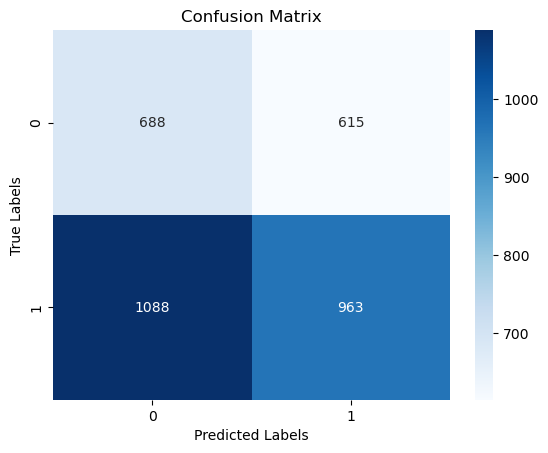

In [106]:
#confusion matrix of the test set
conf_matrix = confusion_matrix(y_test, test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

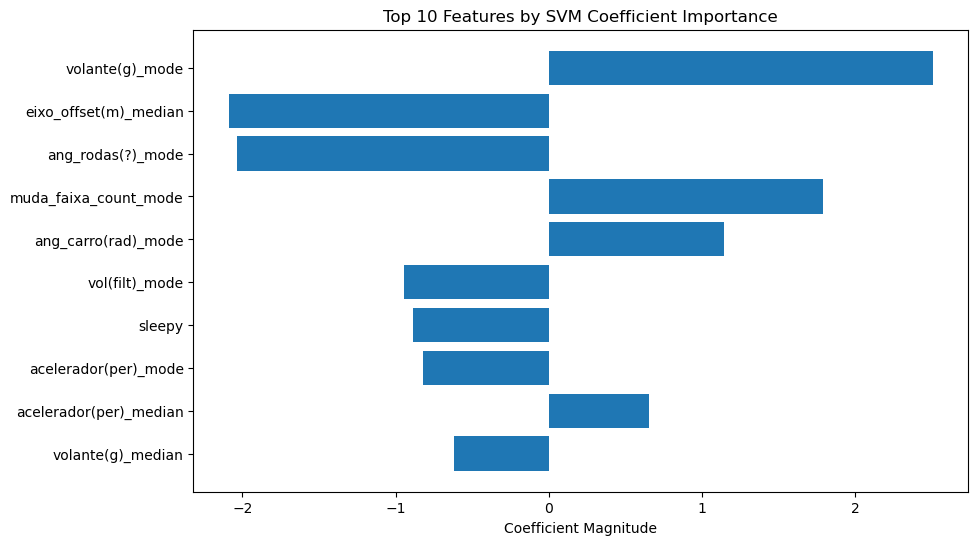

In [48]:
if svm_model.kernel == 'linear':
    # Get the coefficients (weights) of the features
    coefficients = svm_model.coef_[0]

    # Pair the coefficients with the corresponding feature names
    feature_importances = list(zip(X_train_val.columns, coefficients))
    
    # Sort feature importances by absolute value of coefficients
    feature_importances.sort(key=lambda x: abs(x[1]), reverse=True)

    # Extract top 10 features and coefficients
    top_features = [x[0] for x in feature_importances[:10]]
    top_importances = [x[1] for x in feature_importances[:10]]

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(top_features, top_importances, align='center')
    ax.set_xlabel('Coefficient Magnitude')
    ax.set_title('Top 10 Features by SVM Coefficient Importance')
    plt.gca().invert_yaxis()  # Invert y-axis to have highest importance on top
    plt.show()
else:
    print("Feature importances are not available for non-linear SVMs.")

In [ ]:
# Assuming test_pred and y_test are already defined
test_conf_matrix = confusion_matrix(y_test, test_pred)
class_labels = [0, 1]

# Normalize the confusion matrix to get percentages
conf_matrix_normalized = test_conf_matrix.astype('float') / test_conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))

# Annotate the heatmap with counts and percentages
annot = np.empty_like(test_conf_matrix).astype(str)
nrows, ncols = test_conf_matrix.shape
for i in range(nrows):
    for j in range(ncols):
        count = test_conf_matrix[i, j]
        percentage = conf_matrix_normalized[i, j] * 100
        annot[i, j] = f'{count}\n({percentage:.1f}%)'

# Plot the heatmap
sns.heatmap(test_conf_matrix, annot=annot, cmap='Blues', fmt='', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix with Percentages')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestClassifier

# Assuming rf_model is your trained RandomForest model
# and X_train_val is your DataFrame with feature data

# Step 1: Extract and sort feature importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort by importance, descending
top_indices = indices[:10]  # Select top 5 indices

# Step 2: Visualize feature importances
feature_names = X_train_fold.columns
top_feature_names = feature_names[top_indices]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(10), importances[top_indices], color="r", align="center")
plt.xticks(range(10), top_feature_names, rotation=45)
plt.xlim([-1, 10])
plt.show()

# Step 3: Plot partial dependence for the top 5 features
fig, ax = plt.subplots(figsize=(15, 3), nrows=1, ncols=10)
for i, feature_idx in enumerate(top_indices):
    pdp_display = PartialDependenceDisplay.from_estimator(
        rf_model,
        X_train_fold,
        features=[feature_idx],
        feature_names=feature_names,
        ax=ax[i],
        grid_resolution=20  # Adjust grid_resolution for smoother curves
    )
    ax[i].set_title(feature_names[feature_idx])
plt.tight_layout()
plt.show()


In [ ]:
# Partial dependence plot for the first feature using PartialDependenceDisplay
fig, ax = plt.subplots(figsize=(8, 4))
display = PartialDependenceDisplay.from_estimator(rf_model, X_train_fold, features=[23], feature_names=X_train_fold.columns, ax=ax)
plt.show()